In [ ]:
!pip install ultralytics
!pip install clearml
!pip install split-folders
!pip install colorama

In [12]:
import os
import shutil
import splitfolders
import pandas as pd
import numpy as np
from tqdm import tqdm
from colorama import Fore

In [13]:
IMAGE_PATH = "/content/images/images"
TARGET_PATH = "/content/annotation/annotation/YOLO-format"


In [14]:
def create_dataset(data_path: str, target_path: str) -> pd.DataFrame:
    assert isinstance(data_path, str)
    assert isinstance(target_path, str)

    dict_paths = {
        "image": [],
        "annotation": []
    }

    for dir_name, _, filenames in os.walk(data_path):
        for filename in tqdm(filenames):
            name = filename.split('.')[0]
            dict_paths["image"].append(f"{data_path}/{name}.jpg")
            dict_paths["annotation"].append(f"{target_path}/{name}.txt")


    dataframe = pd.DataFrame(
        data=dict_paths,
        index=np.arange(0, len(dict_paths["image"]))
    )

    return dataframe

In [15]:
def prepare_dirs(dataset_path: str,
                 annotation_path: str,
                 images_path: str) -> None:
    if not os.path.exists(dataset_path):
        os.mkdir(path=dataset_path)
        os.mkdir(path=annotation_path)
        os.mkdir(path=images_path)

In [16]:
def copy_dirs(dataframe: pd.DataFrame,
             data_path: str,
             target_path: str) -> None:

    assert isinstance(dataframe, pd.DataFrame)
    assert isinstance(data_path, str)
    assert isinstance(target_path, str)

    for i in tqdm(range(len(dataframe))):
        image_path, annotation_path = dataframe.iloc[i]
        shutil.copy(image_path, data_path)
        shutil.copy(annotation_path, target_path)

In [17]:
def finalizing_preparation(dataset_path: str, ladd_path: str):
    assert os.path.exists(f"{dataset_path}")

    example_structure = [
        "dataset",
        "train", "labels", "images",
        "test","labels", "images",
        "val", "labels", "images"
    ]

    dir_bone = (
        dirname.split("/")[-1]
        for dirname, _, filenames in os.walk('/kaggle/working/dataset')
        if dirname.split("/")[-1] in example_structure
    )

    try:
        print("\n~ Lacmus Dataset Structure ~\n")
        print(
        f"""
      ├── {next(dir_bone)}
      │   │
      │   ├── {next(dir_bone)}
      │   │   └── {next(dir_bone)}
      │   │   └── {next(dir_bone)}
      │   │
      │   ├── {next(dir_bone)}
      │   │   └── {next(dir_bone)}
      │   │   └── {next(dir_bone)}
      │   │
      │   ├── {next(dir_bone)}
      │   │   └── {next(dir_bone)}
      │   │   └── {next(dir_bone)}
        """
        )
    except StopIteration as e:
        print(e)
    else:
        print(Fore.GREEN + "-> Success")
    finally:
        os.system(f"rm -rf {ladd_path}")

In [18]:
df = create_dataset(
    data_path=IMAGE_PATH,
    target_path=TARGET_PATH
)

100%|██████████| 1365/1365 [00:00<00:00, 282058.58it/s]


In [19]:
dataset_path = "/content/dataset"
ladd_path = "../content/ladd"
annotation_path = "/content/ladd/labels"
image_path = "/content/ladd/images"

In [20]:
prepare_dirs(
    dataset_path=ladd_path,
    annotation_path=annotation_path,
    images_path=image_path
)

In [21]:
copy_dirs(
    dataframe=df,
    data_path=image_path,
    target_path=annotation_path
)

100%|██████████| 1365/1365 [01:00<00:00, 22.43it/s]


In [22]:
splitfolders.ratio(
    input=ladd_path,
    output=dataset_path,
    seed=42,
    ratio=(0.80, 0.10, 0.10),
    group_prefix=None,
    move=True
)

Copying files: 2730 files [00:00, 9540.74 files/s]


In [23]:
finalizing_preparation(
    dataset_path,
    ladd_path
)


~ Lacmus Dataset Structure ~




In [24]:
import yaml
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [25]:
config = {
    "path": "/content/dataset",
    "train": "/content/dataset/train/images",
    "val": "/content/dataset/val/images",
    "predict": "/content/test/train/images",
    "nc": 1,
    "names": ["human"]
}

with open("config.yaml", "w") as f:
    yaml.dump(config, f)

with open("config.yaml", "r") as f:
    print(f.read())

names:
- human
nc: 1
path: /content/dataset
predict: /content/test/train/images
train: /content/dataset/train/images
val: /content/dataset/val/images



In [29]:
def main():
    model = YOLO("yolov8n.pt")
    model.train(
        # Project
        project="Polar-Owl",
        name="yolov8n",

        # Random Seed parameters
        deterministic=True,
        seed=42,

        # Data & model parameters
        data="/content/config.yaml",
        save=True,
        save_period=5,
        pretrained=True,
        imgsz=1280,

        # Training parameters
        epochs=20,
        batch=4,
        workers=8,
        val=True,
        device=0,

        # Optimization parameters
        lr0=0.0195,
        patience=3,
        optimizer="SGD",
        momentum=0.957,
        weight_decay=0.0005,
        close_mosaic=5,
    )

In [30]:
if __name__ == '__main__':
    main()

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/config.yaml, epochs=20, patience=3, batch=4, imgsz=1280, save=True, save_period=5, cache=False, device=0, workers=8, project=Polar-Owl, name=yolov8n3, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=5, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize

100%|██████████| 755k/755k [00:00<00:00, 22.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/dataset/train/labels... 1092 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1092/1092 [00:03<00:00, 331.39it/s]

train: New cache created: /content/dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/val/labels... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<00:00, 345.21it/s]


val: New cache created: /content/dataset/val/labels.cache
Plotting labels to Polar-Owl/yolov8n3/labels.jpg... 
optimizer: SGD(lr=0.0195, momentum=0.957) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 2 dataloader workers
Logging results to Polar-Owl/yolov8n3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       4.4G       1.82      2.454      1.012         28       1280: 100%|██████████| 273/273 [05:16<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:31<00:00,  1.88s/it]

                   all        136        606      0.739      0.186       0.37      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.77G      1.897      1.837      1.012         11       1280: 100%|██████████| 273/273 [05:17<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:33<00:00,  1.98s/it]

                   all        136        606      0.433      0.474      0.365       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.52G      2.087      2.038      1.054         23       1280: 100%|██████████| 273/273 [05:13<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:34<00:00,  2.01s/it]

                   all        136        606      0.533      0.445      0.432      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.55G      2.074      1.904      1.085         22       1280: 100%|██████████| 273/273 [05:13<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:32<00:00,  1.90s/it]

                   all        136        606       0.56        0.5      0.487      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.28G      2.017      1.701      1.056         34       1280: 100%|██████████| 273/273 [05:15<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:28<00:00,  1.68s/it]

                   all        136        606       0.55      0.487      0.429      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.9G      1.877      1.533       1.03         15       1280: 100%|██████████| 273/273 [05:07<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:28<00:00,  1.68s/it]

                   all        136        606      0.718       0.52      0.575      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.41G      1.865      1.385      1.035         30       1280: 100%|██████████| 273/273 [05:14<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:30<00:00,  1.78s/it]

                   all        136        606       0.73      0.545      0.585      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.55G      1.788      1.319      1.032         21       1280: 100%|██████████| 273/273 [05:21<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:32<00:00,  1.90s/it]

                   all        136        606      0.694      0.508       0.55      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.14G      1.762      1.278      1.025         11       1280: 100%|██████████| 273/273 [05:10<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:27<00:00,  1.63s/it]

                   all        136        606      0.693      0.552      0.582      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.4G      1.701      1.206      1.003         23       1280: 100%|██████████| 273/273 [05:12<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:29<00:00,  1.76s/it]

                   all        136        606      0.715      0.583      0.611      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         4G      1.685       1.19      1.003          6       1280: 100%|██████████| 273/273 [05:15<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:29<00:00,  1.73s/it]

                   all        136        606      0.671      0.606      0.593      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.46G      1.676      1.157     0.9831          9       1280: 100%|██████████| 273/273 [05:20<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:28<00:00,  1.65s/it]

                   all        136        606      0.748      0.594      0.647      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.45G      1.632      1.132     0.9805         22       1280: 100%|██████████| 273/273 [05:21<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:29<00:00,  1.72s/it]

                   all        136        606      0.757      0.593      0.651       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.48G      1.601      1.085     0.9689         12       1280: 100%|██████████| 273/273 [05:19<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:29<00:00,  1.71s/it]

                   all        136        606      0.756      0.612      0.654      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.65G      1.568      1.072      0.956          8       1280: 100%|██████████| 273/273 [05:32<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:33<00:00,  1.95s/it]

                   all        136        606        0.8      0.616      0.684       0.36


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.59G       1.53      1.034     0.9804          9       1280: 100%|██████████| 273/273 [05:10<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:29<00:00,  1.72s/it]

                   all        136        606      0.771      0.623      0.673      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.65G      1.483     0.9916     0.9663         12       1280: 100%|██████████| 273/273 [05:13<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:29<00:00,  1.75s/it]

                   all        136        606      0.742      0.604      0.658      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.64G      1.452     0.9828     0.9654          7       1280: 100%|██████████| 273/273 [05:16<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:31<00:00,  1.83s/it]

                   all        136        606      0.791      0.604      0.675      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.64G      1.444     0.9424     0.9562         10       1280: 100%|██████████| 273/273 [05:13<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:30<00:00,  1.82s/it]

                   all        136        606       0.81      0.601      0.682      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.58G      1.439     0.9235     0.9557          7       1280: 100%|██████████| 273/273 [05:20<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:27<00:00,  1.64s/it]

                   all        136        606      0.778       0.63      0.699      0.399



20 epochs completed in 1.934 hours.
Optimizer stripped from Polar-Owl/yolov8n3/weights/last.pt, 6.4MB
Optimizer stripped from Polar-Owl/yolov8n3/weights/best.pt, 6.4MB

Validating Polar-Owl/yolov8n3/weights/best.pt...
Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:28<00:00,  1.65s/it]


                   all        136        606      0.779      0.625      0.699      0.399
Speed: 0.8ms preprocess, 9.9ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to Polar-Owl/yolov8n3


In [34]:
model = YOLO("/content/Polar-Owl/yolov8n3/weights/best.pt")


image 1/1 /content/dataset/test/images/1052.jpg: 736x1280 1 human, 17.4ms
Speed: 10.4ms preprocess, 17.4ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


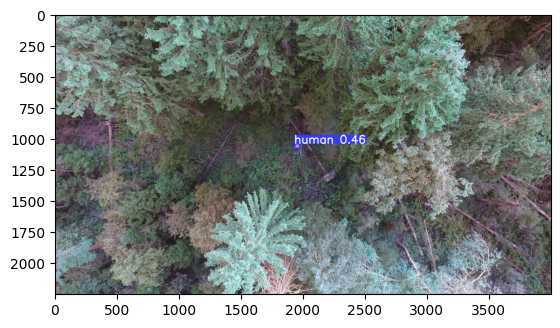

In [40]:
history = model.predict("/content/dataset/test/images/1052.jpg", conf=0.1)[0]
image = history.plot()
plt.imshow(image)
plt.show()